In [1]:
# reading file from a filepath with apache spark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings("ignore")

# creating an instance of spark context class
sc = SparkContext.getOrCreate(SparkConf().setMaster('local[*]'))
spark = SparkSession.builder.appName('Data Exploration').getOrCreate()

## Data <a name="data"></a>

In [2]:
rdd = sc.textFile('Dataset/nyc_jobPostings.csv')
df = spark.read.csv(rdd, header=True)
df.show()

+------+--------------------+------------+---------+--------------------+--------------------+-------------+-----+--------------------+-----------------------------+-----------------+---------------+----------------+--------------------+--------------------+--------------------+-------------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+
|Job ID|              Agency|Posting Type|Vacancies|      Business Title| Civil Service Title|Title Code No|Level|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|Salary Frequency|       Work Location|  Division/Work Unit|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|            To Apply|         Hours/Shift|     Work Location 1| Recruitment Contact|Residency Requirement|     

In [3]:
# separate required columns
df1 = df[['Job ID', 'Agency', 'Vacancies', 'Business Title', 'Job Category', 'Full-Time/Part-Time indicator', 'Salary Range From', 'Salary Range To', 'Work Location', 'Job Description', 'Minimum Qual Requirements', 'Preferred Skills', 'Additional Information']]
df1.show()

+------+--------------------+---------+--------------------+--------------------+-----------------------------+-----------------+---------------+--------------------+--------------------+-------------------------+--------------------+----------------------+
|Job ID|              Agency|Vacancies|      Business Title|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|       Work Location|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|
+------+--------------------+---------+--------------------+--------------------+-----------------------------+-----------------+---------------+--------------------+--------------------+-------------------------+--------------------+----------------------+
| 87990|DEPARTMENT OF BUS...|        1|     Account Manager|                null|                         null|            42405|          65485| 110 William St. N Y|Division of Econo...|     "1.	A baccalaurea...| all candidat

In [4]:
# ensuring all columns have proper datatypes
# !pip install pyspark
from pyspark.sql.types import *

df1 = df1.withColumn('Vacancies', df1['Vacancies'].cast(IntegerType()))
df1 = df1.withColumn('Salary Range From', df1['Salary Range From'].cast(FloatType()))
df1 = df1.withColumn('Salary Range To', df1['Salary Range To'].cast(FloatType()))
df1.dtypes

[('Job ID', 'string'),
 ('Agency', 'string'),
 ('Vacancies', 'int'),
 ('Business Title', 'string'),
 ('Job Category', 'string'),
 ('Full-Time/Part-Time indicator', 'string'),
 ('Salary Range From', 'float'),
 ('Salary Range To', 'float'),
 ('Work Location', 'string'),
 ('Job Description', 'string'),
 ('Minimum Qual Requirements', 'string'),
 ('Preferred Skills', 'string'),
 ('Additional Information', 'string')]

In [5]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")        # fastens toPandas conversion for large datasets
df_p = df1.toPandas()
print(df_p.dtypes)
df_p.head()

Job ID                            object
Agency                            object
Vacancies                          int32
Business Title                    object
Job Category                      object
Full-Time/Part-Time indicator     object
Salary Range From                float32
Salary Range To                  float32
Work Location                     object
Job Description                   object
Minimum Qual Requirements         object
Preferred Skills                  object
Additional Information            object
dtype: object


,Job ID,Agency,Vacancies,Business Title,Job Category,Full-Time/Part-Time indicator,Salary Range From,Salary Range To,Work Location,Job Description,Minimum Qual Requirements,Preferred Skills,Additional Information
0,87990,DEPARTMENT OF BUSINESS SERV.,1,Account Manager,None,None,42405.000000,65485.000000,110 William St. N Y,Division of Economic & Financial Opportunity (...,"""1.\tA baccalaureate degree from an accredited...",all candidates must have at least one year of...,â€¢\tExcellent interpersonal and organizationa...
1,97899,DEPARTMENT OF BUSINESS SERV.,1,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",None,F,60740.000000,162014.000000,110 William St. N Y,The New York City Department of Small Business...,"""1. A baccalaureate degree from an accredited ...",None,None
2,132292,NYC HOUSING AUTHORITY,52,Maintenance Worker - Technical Services-Heatin...,Maintenance & Operations,F,51907.679688,54580.320312,Heating Mgt-Operations,"Under direct supervision, assist in the routin...","""1. Three years of full-time satisfactory expe...",mechanical,or construction trades in a trade school or v...
3,132292,NYC HOUSING AUTHORITY,52,Maintenance Worker - Technical Services-Heatin...,Maintenance & Operations,F,51907.679688,54580.320312,Heating Mgt-Operations,"Under direct supervision, assist in the routin...","""1. Three years of full-time satisfactory expe...",mechanical,or construction trades in a trade school or v...
4,133921,NYC HOUSING AUTHORITY,50,Temporary Painter,Maintenance & Operations,F,35.000000,35.000000,DMP-Contract & Analysis Unit,Responsibilities of selected candidates will i...,1. Five years of full-time satisfactory experi...,None,SPECIAL NOTE: 1. This is a temporary assig...


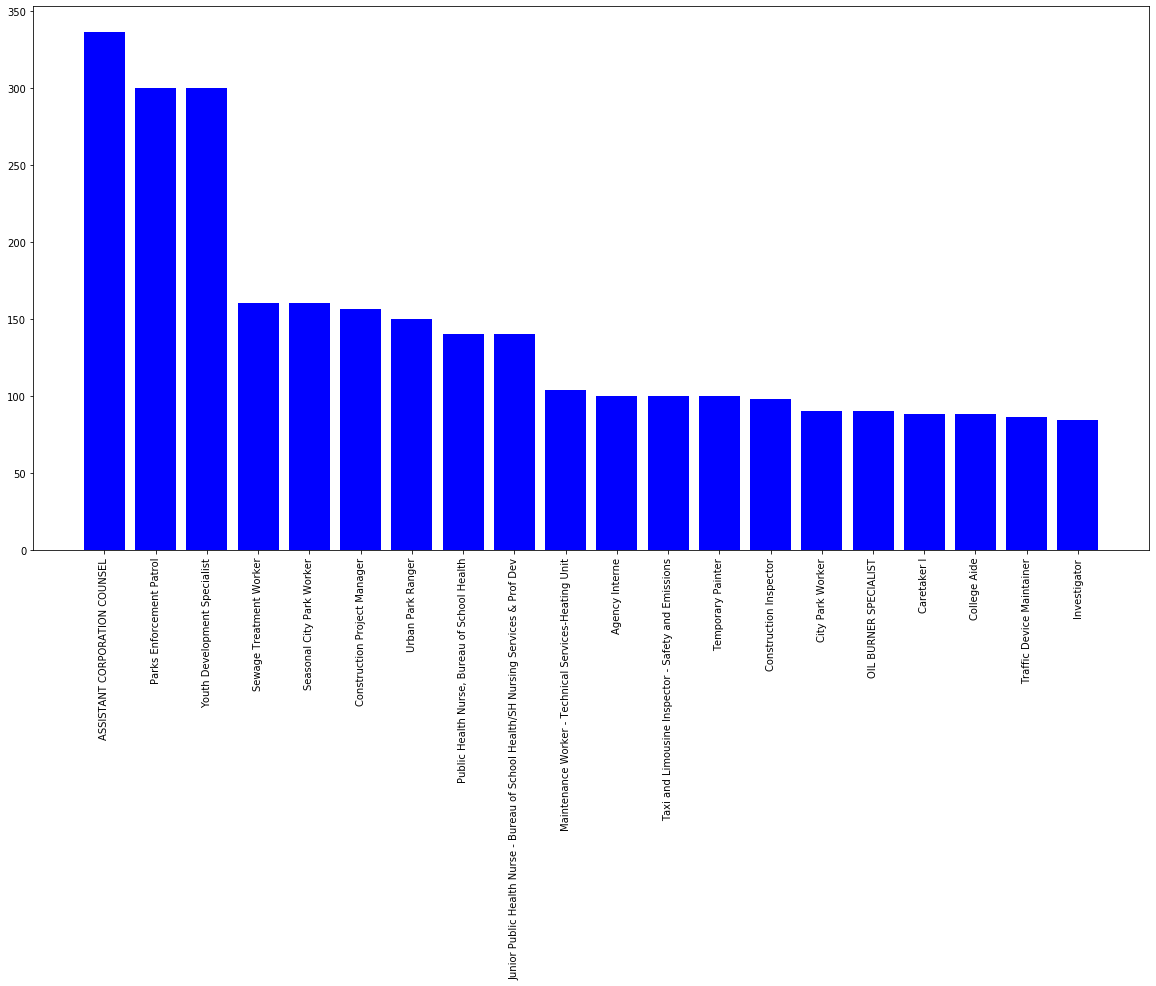

In [6]:
# visualization for number of positions for each job
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df_vacancies = df_p.groupby('Business Title')['Vacancies'].sum().sort_values(ascending=False).head(20)
df_vacancies = df_vacancies.reset_index()

plt.figure(figsize=(20, 10))
plt.bar(df_vacancies['Business Title'], df_vacancies['Vacancies'], color='blue')
plt.xticks(df_vacancies['Business Title'], rotation=90)
plt.show()

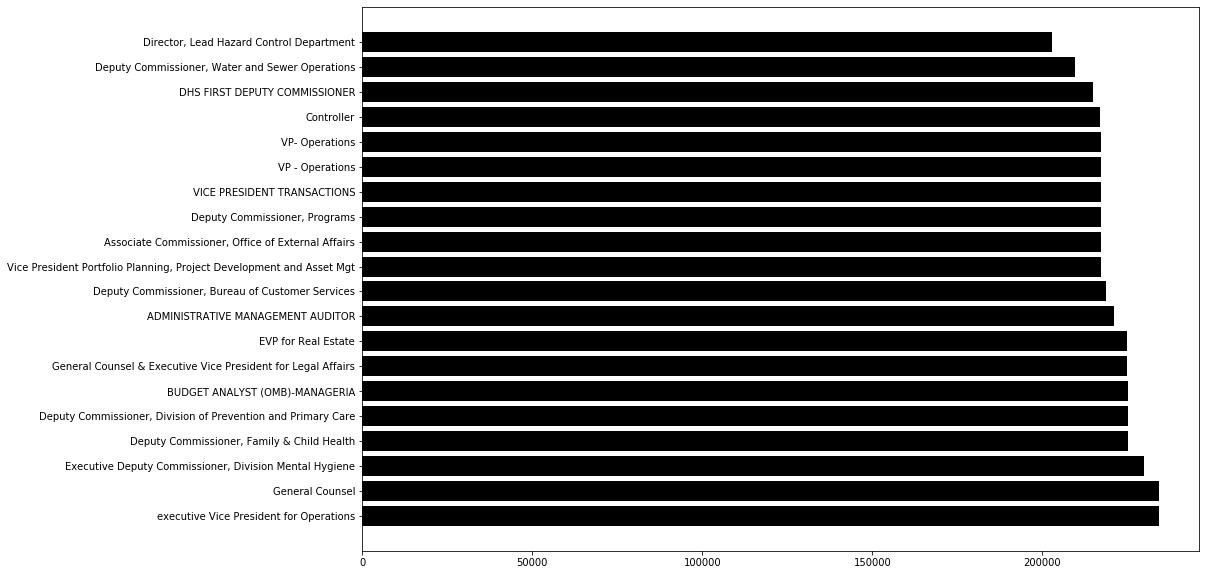

In [7]:
# visualization for highest salary jobs
df_pay = df_p.groupby('Business Title')['Salary Range To'].mean().sort_values(ascending=False).head(20)
df_pay = df_pay.reset_index()

plt.figure(figsize=(15, 10))
plt.barh(df_pay['Business Title'], df_pay['Salary Range To'], color='black')
plt.show()

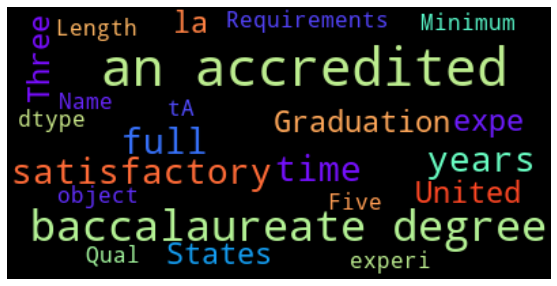

In [8]:
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

sw = ['tA', 'th', 'tAt'] + list(STOPWORDS)

# generating a wordcloud image out of minimum qulaity requirements
plt.figure(figsize=(15, 5))
wc = WordCloud(stopwords=sw, colormap='rainbow', max_words=200).generate_from_text(str(df_p['Minimum Qual Requirements']))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

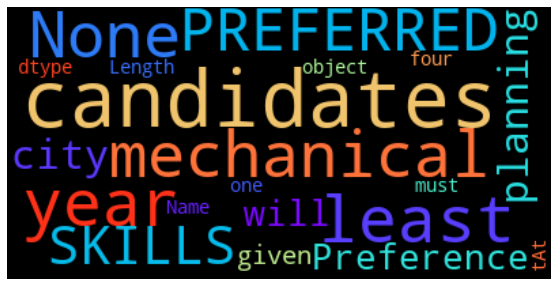

In [9]:
# generating a wordcloud image out of preferred skills
plt.figure(figsize=(15, 5))
wc = WordCloud(stopwords=sw, colormap='rainbow', max_words=200).generate_from_text(str(df_p['Preferred Skills']))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Methodology <a name="methodology"></a>

In [10]:
# majority of the missing value columns are non numerical, hence can't be modified and also can't be deleted as it would reduce the dataset
# ****making an assumption about Full-Time/Part-Time indicator column and replacing the null columns only
from pyspark.sql.functions import when, col

df1 = df1.withColumn('Full-Time/Part-Time indicator', \
                     when((df1['Salary Range From'] > 50) & (col('Full-Time/Part-Time indicator').isNull()), 'F').otherwise(df1['Full-Time/Part-Time indicator']))

df1 = df1.withColumn('Full-Time/Part-Time indicator', \
                     when((df1['Salary Range From'] < 50) & (col('Full-Time/Part-Time indicator').isNull()), 'P').otherwise(df1['Full-Time/Part-Time indicator']))

df1.show()

+------+--------------------+---------+--------------------+--------------------+-----------------------------+-----------------+---------------+--------------------+--------------------+-------------------------+--------------------+----------------------+
|Job ID|              Agency|Vacancies|      Business Title|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|       Work Location|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|
+------+--------------------+---------+--------------------+--------------------+-----------------------------+-----------------+---------------+--------------------+--------------------+-------------------------+--------------------+----------------------+
| 87990|DEPARTMENT OF BUS...|        1|     Account Manager|                null|                            F|          42405.0|        65485.0| 110 William St. N Y|Division of Econo...|     "1.	A baccalaurea...| all candidat

### Feature Engineering

In [11]:
# separating strings in minimum qual requirements and preferred skills column and applying one-hot encoding
# challenges:
# 1. Strings are saparated by random punctuation marks rather than commas
# 2. Number of string values in the column for each job is different
# splitting the strings and put them in a single list
from pyspark.sql.functions import split

df_mqr = df1.withColumn('Minimum Qual Requirements', split('Minimum Qual Requirements', ' '))   # using , as delimiter will give error in keywords detection
df_ps = df_mqr.withColumn('Preferred Skills', split('Preferred Skills', ' ')) 

df_red = df_ps[['Business Title', 'Vacancies', 'Salary Range From', 'Minimum Qual Requirements', 'Preferred Skills', 'Work Location']]
df_red.show()

+--------------------+---------+-----------------+-------------------------+--------------------+--------------------+
|      Business Title|Vacancies|Salary Range From|Minimum Qual Requirements|    Preferred Skills|       Work Location|
+--------------------+---------+-----------------+-------------------------+--------------------+--------------------+
|     Account Manager|        1|          42405.0|     ["1.	A, baccalaur...|[, all, candidate...| 110 William St. N Y|
|EXECUTIVE DIRECTO...|        1|          60740.0|     ["1., A, baccalau...|                null| 110 William St. N Y|
|Maintenance Worke...|       52|         51907.68|     ["1., Three, year...|      [, mechanical]|Heating Mgt-Opera...|
|Maintenance Worke...|       52|         51907.68|     ["1., Three, year...|      [, mechanical]|Heating Mgt-Opera...|
|   Temporary Painter|       50|             35.0|     [1., Five, years,...|                null|DMP-Contract & An...|
|   Temporary Painter|       50|             35.

In [12]:
# counting number of values in minimum qual requirements and preferred skills
from pyspark.sql.functions import size

mqr = df_red.select('*', size('Minimum Qual Requirements').alias('Qualities Count'))
ps = mqr.select('*', size('Preferred Skills').alias('Skills Count'))

ps.show()

+--------------------+---------+-----------------+-------------------------+--------------------+--------------------+---------------+------------+
|      Business Title|Vacancies|Salary Range From|Minimum Qual Requirements|    Preferred Skills|       Work Location|Qualities Count|Skills Count|
+--------------------+---------+-----------------+-------------------------+--------------------+--------------------+---------------+------------+
|     Account Manager|        1|          42405.0|     ["1.	A, baccalaur...|[, all, candidate...| 110 William St. N Y|             71|          16|
|EXECUTIVE DIRECTO...|        1|          60740.0|     ["1., A, baccalau...|                null| 110 William St. N Y|            140|          -1|
|Maintenance Worke...|       52|         51907.68|     ["1., Three, year...|      [, mechanical]|Heating Mgt-Opera...|             63|           2|
|Maintenance Worke...|       52|         51907.68|     ["1., Three, year...|      [, mechanical]|Heating Mgt-Ope

In [13]:
# some preferred skills have size = -1 (data loss)
# finding correlation between salary and minimum qual requirements and preferred skills 
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import Normalizer

assembler = VectorAssembler(inputCols=['Salary Range From', 'Qualities Count', 'Skills Count'], outputCol='Vector_Col')
assembled = assembler.transform(ps).select('Vector_Col')
matrix = Correlation.corr(assembled, 'Vector_Col')
matrix.collect()[0]['pearson({})'.format('Vector_Col')].values

array([ 1.        , -0.00607287,  0.16130972, -0.00607287,  1.        ,
       -0.08856486,  0.16130972, -0.08856486,  1.        ])